In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sn
import gc

from joblib import Parallel, delayed
from tqdm import tqdm
from easydict import EasyDict as edict
from sklearn.linear_model import LogisticRegression

from samplers import *
from datgen import *

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
nH = 500 # sample size for the historical data
n = 200 # current data
K = 3 # number of historical data
rho = 0.1 # correlation coefficient
d = 6 # dimension
m_threshold = 0.1 # balance treshold

# coefficient of the response surface
theta = np.array([1,1]+[1]*d)
sigmat = rho*np.ones((d,d))+(1-rho)*np.eye(d)

theta1 = {
    '1': [1,1,1],
    '2': [0.8,1.1,1.3],
    '3': [0.8,1.1,1.3]
}

# coefficient of the covariates
X_means = {'1':[0,0,0],
           '2':[0,0,0],
           '3':[0.5,1,1.5]}

X_stds =  {'1':[1,1,1],
           '2':[1,1,1],
           '3':[0.5,1.5,2]}

betas = [np.array([0,0]+[0.2]*2+[-0.2]*2),
         np.array([1,1]+[1]*2+[-1]*2),
         np.array([2,2]+[2]*2+[-2]*2)]


# simulation scenarios
scenarios = [1,2,3]

# replications & simulations
reps = 200
num_cores = 30
random_state = 2021

# cov_adj in RWD and RCT
cov_adj_datgen = True
cov_adj_pred = True

In [3]:
import seaborn as sn
import matplotlib.pyplot as plt

/home/r13user2/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/r13user2/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/r13user2/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibili

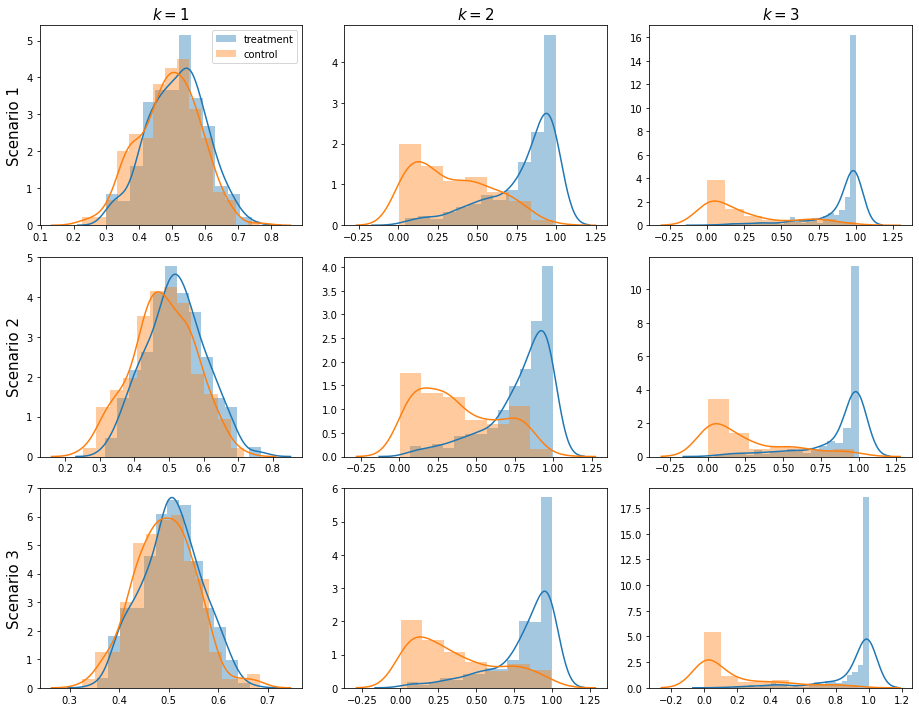

In [4]:
def sigmoid(x):
    return np.exp(x)/(1+np.exp(x))

np.random.seed(2021)

fig, axs = plt.subplots(3,3,figsize=(13,10))
for scenario in [1,2,3]:
    for k in range(K):

        betak = betas[k]

        thetak = theta.copy()
        thetak[1] = theta1[str(scenario)][k]
        
        sigmatk = rho*np.ones((d,d))+(X_stds[str(scenario)][k]-rho)*np.eye(d)

        Xk = np.random.multivariate_normal(X_means[str(scenario)][k]*np.ones(d),sigmatk,size=nH)
        Xk[:,:int(0.4*d)] = np.array(Xk[:,:int(0.4*d)]>X_means[str(scenario)][k],dtype=float)

        Xb = np.dot(Xk,betak)
        psk_true = sigmoid(Xb)
        Tk = np.random.binomial(1,psk_true,psk_true.shape[0])

        plt.subplot(axs[scenario-1,k])
        sn.distplot(psk_true[Tk==1],label='treatment')
        sn.distplot(psk_true[Tk==0],label='control')
        if scenario == 1:
            plt.title('$k={}$'.format(k+1),fontsize=15)
        if (k==0) and (scenario==1):
            plt.legend()
        if k == 0:
            plt.ylabel('Scenario {}'.format(scenario),fontsize=15)
        else:
            plt.ylabel('',fontsize=15)

plt.tight_layout()
plt.savefig('./results/ps_distplot.pdf')
plt.show()